In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

import sys
sys.path.insert(0, '../src/')

import methods
import time

In [2]:
def apply_rff(A, k, sigma=1):
    n = A.shape[1]
    A_g = A = A.dot(sigma * np.random.randn(n, k))
    A_sin = np.sin(A_g)
    A_cos = np.cos(A_g)
    A_rff = np.zeros((A.shape[0], 2 * A_cos.shape[1]))
    A_rff[:, 0:A_rff.shape[1]:2] = A_cos
    A_rff[:, 1:A_rff.shape[1]:2] = A_sin
    return A_rff / np.sqrt(k)

## Function approximtion in 2D

###  $f(x) = a^{\top}x + c + \alpha \exp(-\frac{(\|x\| - \mu)^2}{\sigma})$

In [3]:
x, y = np.meshgrid(np.random.rand(100), np.random.rand(100))
A = np.vstack((x.reshape(-1), y.reshape(-1))).T

In [4]:
a = np.ones(2)
c = 1
alpha = 0.1
mu = 0
sigma = 1
b = A @ a + c + alpha * np.exp(-(np.sqrt(np.sum(A**2, axis=1)) - mu) / sigma)
b = b[:, np.newaxis]
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

0.1954690109627239


## Apply explicit feature map via random Fourier features

In [5]:
# The dimension after RFF is 2*d 
d = 7
A = apply_rff(A, d)
m, n = A.shape
print(A.shape, b.shape)

(10000, 14) (10000, 1)


In [6]:
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

0.0003726628810643217


## Build preconditioners

In [7]:
preprocess_time = {
    "$\gamma = 2$": 0,
    "$\gamma = 3$": 0,
    "$\gamma = 4$": 0,
}
sketch_sizes = [i * n for i in range(2, 5)]
P = {name: [] for name in preprocess_time}

In [8]:
P = {}
for k, i in enumerate(range(2, 5)):
    print("Sketch size = {}".format(n * i))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
    P["$\gamma = {}$".format(i)] = np.linalg.inv(R_qr)
    preprocess_time["$\gamma = {}$".format(i)] = time.time() - st

Sketch size = 28
Sketch size = 42
Sketch size = 56


In [9]:
preprocess_time

{'$\\gamma = 2$': 0.0030126571655273438,
 '$\\gamma = 3$': 0.0008788108825683594,
 '$\\gamma = 4$': 0.0015869140625}

In [10]:
max_iter = 3000000
tol = 1e-6
x0 = np.zeros(n)
max_time = 3.
log_interval = 1000

In [11]:
conv_x_res = {"No preconditioning": []}
conv_time_res = {"No preconditioning": []}

In [12]:
res = methods.classical_kaczmarz(A, b, x0, max_iter, max_time, log_interval)
conv_x_res["No preconditioning"] = res["conv_x"]
conv_time_res["No preconditioning"] = res["conv_time"]

In [13]:
for name in preprocess_time:
    print(name)
    res = methods.precond_kaczmarz(A, b, P[name], 
                             x0, max_iter, max_time, 
                             log_interval, preprocess_time[name])
    conv_x_res[name] = res["conv_x"]
    conv_time_res[name] = res["conv_time"]

$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


In [14]:
relative_residual_norm = {}
for name in conv_x_res:
    relative_residual_norm[name] = []
    if P.get(name) is None:
        for x in conv_x_res[name]:
            relative_residual_norm[name].append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
    else:
        for x in conv_x_res[name]:
            relative_residual_norm[name].append(np.linalg.norm(A @ (P[name] @ x) - b) / np.linalg.norm(b))

## Relative error vs. number of iterations

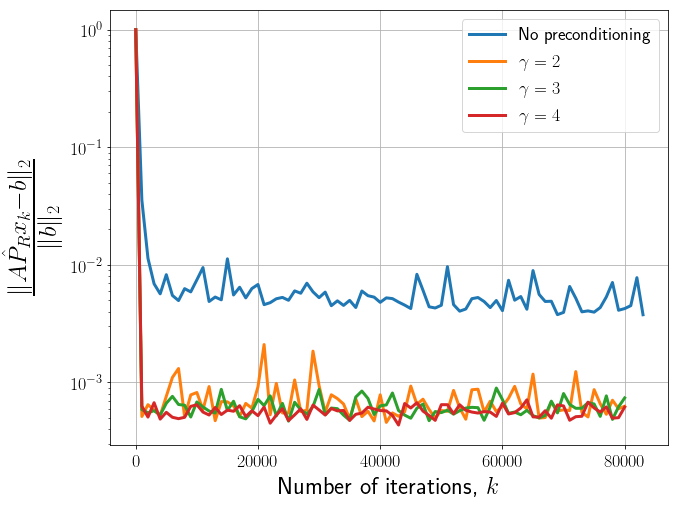

In [15]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    iter_range = [j * log_interval for j in range(len(conv_x_res[name]))]
    plt.semilogy(iter_range, relative_residual_norm[name], label=name, linewidth=3)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=36)
plt.xlabel(r"Number of iterations, $k$", fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
_ = plt.yticks(fontsize=18)
_ = plt.xticks(fontsize=18)

No preconditioning
$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


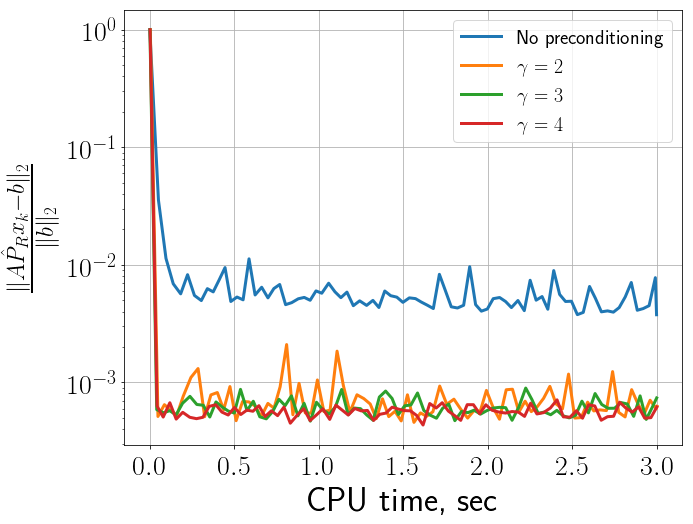

In [16]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    print(name)
    time_range = conv_time_res[name][::log_interval] + [conv_time_res[name][-1]]
    plt.semilogy(time_range, relative_residual_norm[name], label=name, linewidth=3)

plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=34)
plt.xlabel(r"CPU time, sec", fontsize=34)
plt.legend(fontsize=20)
_ = plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28)
plt.grid(True)